# Notebook 02: Regression Model

**Student Name:** Sean McManus

**Dataset:** Global_Space_Exploration_Dataset.csv

**Target Variable:** success_rate

**Checkpoint 3 Due:** Feb 15

---

## Rules & Integrity

1. **NO AI TOOLS**: You may **NOT** use ChatGPT, Claude, Gemini, GitHub Copilot, or any other AI assistant to generate code for this assignment. The goal is to build *your* fundamental skills. If you rely on AI now, the advanced topics later will be impossible.

2. **Study Groups Encouraged**: You **ARE** encouraged to discuss ideas, share approaches, and explain concepts to your study group peers. Teaching others is the best way to learn! However, the code you submit must be **your own work**.

3. **Use Your Resources**: You are free to use Google, StackOverflow, Pandas/Scikit-learn documentation, and your class notes.

4. **Comment Your Code**: Include comments explaining *why* you're doing what you're doing. I want to see your thought process.

5. **Resubmission**: You may submit this assignment multiple times for feedback before the checkpoint deadline.

---

## Important: Written Reflections

Throughout this notebook, you'll be asked to interpret results, justify decisions, and explain your reasoning. **These written reflections are a critical part of your grade.**

Good data scientists don't just run code—they communicate their findings clearly. Take time to write thoughtful, complete responses to all reflection prompts. This demonstrates your understanding and prepares you for real-world stakeholder communication.

---

## Setup

In [203]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Sklearn - models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Sklearn - evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model saving
import joblib

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## Section 1: Load Processed Data

In [204]:
# Load cleaned data from previous notebook
df = pd.read_csv("Global_Space_Exploration_Dataset.csv")

print(f"Data shape: {df.shape}")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Global_Space_Exploration_Dataset.csv'

In [ ]:
print(df.columns.tolist()) #Quick check to confirm name


['Year', 'Budget (in Billion $)', 'Success Rate (%)', 'Duration (in Days)', 'Num_Collaborators', 'Tech_Maturity', 'Budget_Per_Day', 'Mission Type_Unmanned', 'Technology Used_Nuclear Propulsion', 'Technology Used_Reusable Rocket', 'Technology Used_Solar Propulsion', 'Technology Used_Traditional Rocket', 'Country_France', 'Country_Germany', 'Country_India', 'Country_Israel', 'Country_Japan', 'Country_Russia', 'Country_UAE', 'Country_UK', 'Country_USA', 'Satellite Type_Navigation', 'Satellite Type_Research', 'Satellite Type_Spy', 'Satellite Type_Weather', 'Environmental Impact_Low', 'Environmental Impact_Medium', 'Tech_Budget_Power']


In [ ]:
# Define your target variable
TARGET = 'Success Rate (%)'  # <-- UPDATE THIS!

print(f"Target: {TARGET}")
print(f"\nTarget statistics:")
print(df[TARGET].describe())

# Store target range for later interpretation
target_range = df[TARGET].max() - df[TARGET].min()
target_std = df[TARGET].std()
print(f"\nTarget range: {target_range:,.2f}")
print(f"Target std: {target_std:,.2f}")

Target: Success Rate (%)

Target statistics:
count    3000.000000
mean       74.985000
std        14.945252
min        50.000000
25%        62.000000
50%        75.000000
75%        88.000000
max       100.000000
Name: Success Rate (%), dtype: float64

Target range: 50.00
Target std: 14.95


## Section 2: Prepare Features and Target

In [ ]:
# Separate features (X) and target (y)
X = df.drop(columns=[TARGET])
y = df[TARGET]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nAll features ({len(X.columns)}):")
print(X.columns.tolist())

Features shape: (3000, 27)
Target shape: (3000,)

All features (27):
['Year', 'Budget (in Billion $)', 'Duration (in Days)', 'Num_Collaborators', 'Tech_Maturity', 'Budget_Per_Day', 'Mission Type_Unmanned', 'Technology Used_Nuclear Propulsion', 'Technology Used_Reusable Rocket', 'Technology Used_Solar Propulsion', 'Technology Used_Traditional Rocket', 'Country_France', 'Country_Germany', 'Country_India', 'Country_Israel', 'Country_Japan', 'Country_Russia', 'Country_UAE', 'Country_UK', 'Country_USA', 'Satellite Type_Navigation', 'Satellite Type_Research', 'Satellite Type_Spy', 'Satellite Type_Weather', 'Environmental Impact_Low', 'Environmental Impact_Medium', 'Tech_Budget_Power']


In [ ]:
# Check for any non-numeric columns that need to be handled
non_numeric = X.select_dtypes(include=['object', 'category']).columns.tolist()
if non_numeric:
    print(f"Warning: Non-numeric columns found: {non_numeric}")
    print("You need to encode these or go back to Notebook 01!")
else:
    print("All features are numeric. Ready to proceed!")

All features are numeric. Ready to proceed!


## Section 3: Train-Test Split

Split your data into training and test sets. The training set is used to train the model, and the test set is used to evaluate how well it generalizes to unseen data.

In [ ]:
# TODO: Split your data into training and test sets
# 
# Requirements:
# - Use an 80/20 split (test_size=0.2)
# - Set random_state=42 for reproducibility # the best number
# - Store results in: X_train, X_test, y_train, y_test

# Hint: Use train_test_split(X, y, ...)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)
# lest check this worked
print(f"Training set: {X_train.shape[0]} missions")
print(f"Testing set: {X_test.shape[0]} missions")
print(f"Total features: {X_train.shape[1]}")

#thanks David for that check


Training set: 2400 missions
Testing set: 600 missions
Total features: 27


In [ ]:
# Verify your split (run this cell to check)
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.0f}%)")

Training set: 2,400 samples (80%)
Test set: 600 samples (20%)


## Section 4: Feature Scaling

Many ML algorithms perform better when features are on similar scales. StandardScaler transforms features to have mean=0 and std=1.

**Important:** Fit the scaler on training data only, then transform both train and test. This prevents data leakage.

In [ ]:
# TODO: Scale your features using StandardScaler
#
# Steps:
# 1. Create a StandardScaler instance #### Instance???  = object = the actual scaler i will use
# 2. Fit the scaler on X_train and transform X_train (use fit_transform)  ### ok fit_transform will calculate mean and standard dev of X-train
# 3. Transform X_test using the same scaler (use transform only - NOT fit_transform!)
# 4. Store results in: X_train_scaled, X_test_scaled
#
# Why fit only on train? To prevent "data leakage" - test data should be truly unseen.
# Its Scaler // not scalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)    ##PUT CORRECT SET IN SCALER FIT TRANSFORM***Not testing data X_TRAIN IMportant

#!!from step 3!!! dont use fit_transform for test data 
X_test_scaled = scaler.transform(X_test)



In [ ]:
# Convert back to DataFrame for easier viewing (optional but helpful)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Verify scaling worked
print("Features scaled successfully!")
print(f"\nScaled feature means (should be ~0): {X_train_scaled.mean().mean():.4f}")
print(f"Scaled feature stds (should be ~1): {X_train_scaled.std().mean():.4f}")

Features scaled successfully!

Scaled feature means (should be ~0): -0.0000
Scaled feature stds (should be ~1): 1.0002


## Section 5: Baseline Model

Start with a simple Linear Regression to establish a baseline performance. This gives us a reference point for improvement.

In [ ]:
# This helper function evaluates any model - you'll use it throughout this notebook
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train model and return evaluation metrics."""
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }
    
    return results, model, y_test_pred

In [ ]:
# TODO: Create and evaluate a baseline Linear Regression model
#
# Steps:
# 1. Create a LinearRegression() model instance
# 2. Use the evaluate_model() function to train and evaluate it
# 3. Store the results  ### DICTIONARY
#
# The evaluate_model function returns: (results_dict, trained_model, predictions)

# YOUR CODE HERE:
# baseline_model = ...
# baseline_results, baseline_trained, baseline_preds = evaluate_model(...)
baseline_model = LinearRegression()
#scaled data is what is necissary for the dictinary
baseline_results, baseline_trained, baseline_preds = evaluate_model(
    model = baseline_model,
    X_train = X_train_scaled,  ##USE SCALED DATA
    X_test = X_test_scaled,
    y_train = y_train,
    y_test = y_test,
    model_name = "Baseline Spaceline Linear Regression Model"
)
#/// dictionary classification is case sensitive frm now on!! (*model mistake*)

In [ ]:
# Display baseline results
print("=" * 50)
print("BASELINE MODEL: Linear Regression")
print("=" * 50)
print(f"Train R²: {baseline_results['Train R2']:.4f}")
print(f"Test R²:  {baseline_results['Test R2']:.4f}")
print(f"Test RMSE: {baseline_results['Test RMSE']:,.2f}")
print(f"Test MAE: {baseline_results['Test MAE']:,.2f}")

# Context for RMSE
print(f"\n--- RMSE in Context ---")
print(f"RMSE as % of target range: {baseline_results['Test RMSE']/target_range*100:.1f}%")
print(f"RMSE as % of target std: {baseline_results['Test RMSE']/target_std*100:.1f}%")

BASELINE MODEL: Linear Regression
Train R²: 0.0076
Test R²:  -0.0096
Test RMSE: 15.28
Test MAE: 13.34

--- RMSE in Context ---
RMSE as % of target range: 30.6%
RMSE as % of target std: 102.2%


In [ ]:
print(pd.Series(baseline_results)) ## SUber neat way i can do this n the future

Model         Baseline Spaceline Linear Regression Model
Train R2                                        0.007616
Test R2                                        -0.009644
Train RMSE                                     14.819956
Test RMSE                                      15.277089
Train MAE                                      12.879073
Test MAE                                       13.338825
dtype: object


### Baseline Interpretation

*Analyze your baseline results:*

**Understanding your metrics:**
- **R² (0 to 1)**: How much variance in target is explained by features. 0.7+ is often considered good. # :/
- **RMSE**: Average prediction error in the same units as your target. Lower is better.
- **RMSE as % of range**: Helps you understand if errors are big or small relative to your data.

**Questions to answer:**
- What does your R² score tell you about how well features explain the target?
- Is there a big gap between train and test R²? (Gap > 0.1 could indicate overfitting)
- Is your RMSE reasonable? (e.g., if predicting house prices, is a $20K error acceptable?)

**Your interpretation:**

-Ok so test R^2 of 0.0096 (about 0.01 )... thats worse than guessing the success rate of each mission.. and the train r^2 is 0.0076. So the features are explaining less that 1% of the variations in missions and success rates, and can be considered "blind".
-There is no big gap. the train and test R^2 are both around zero. So the mode lisnt overfitting, but since these values are so low its Underfitting.. this is probably not be the model I should use.
- the RMSE is 15.28 and my target variable is success rate of a dadgum Space mission worth billions of dollars, which is a percentage range from 0-100. 15% is a HUGE issue for a space mission. So not reasonable, definitely not for the kind of predictions we need to make; Expensive Predictions. Maybe even life dependant missions. 

I might have to trim this down. I have so many columns. i think it might have too many features. especially the One-hot encoded ones. if my missions are either (FAILURE) or (Success) theres not much middle ground to navigate, maybe making a regression model difficult for this situation.

## Section 6: Model Iteration

Try at least 2-3 different models to see if you can improve on the baseline.

lets go with ridge first for the noisy features.

In [ ]:
# Store all results for comparison
all_results = [
    baseline_results, 
]

# Dictionary to store trained models
trained_models = {
    "Linear Regression (Baseline)": baseline_trained
}

print(all_results)
print("--------------------------------")
print(trained_models)

[{'Model': 'Linear Regression', 'Train R2': 0.0076292817277441305, 'Test R2': -0.009146278253543638, 'Train RMSE': 14.819858629152304, 'Test RMSE': 15.27332487401354, 'Train MAE': 12.879611517177812, 'Test MAE': 13.33524233818785}]
--------------------------------
{'Linear Regression (Baseline)': LinearRegression()}


In [ ]:
"""
ridge_results, ridge_trained, ridge_preds = evaluate_model(
    Ridge(alpha=1.0), 
    X_train_scaled, X_test_scaled, y_train, y_test, 
    "Ridge Regression"
)
print(pd.Series(ridge_results))
"""

'\nridge_results, ridge_trained, ridge_preds = evaluate_model(\n    Ridge(alpha=1.0), \n    X_train_scaled, X_test_scaled, y_train, y_test, \n    "Ridge Regression"\n)\nprint(pd.Series(ridge_results))\n'

### Model 2: Ridge Regression

Ridge adds L2 regularization to prevent overfitting by penalizing large coefficients.

In [ ]:
# TODO: Create and evaluate a Ridge Regression model
#
# Create a Ridge model with alpha=1.0
# Use evaluate_model() to train and evaluate
# Add results to all_results list
# Add trained model to trained_models dict

ridge_model = Ridge(alpha=1.0)
ridge_results, ridge_trained, ridge_preds = evaluate_model(
    model = ridge_model,
    X_train = X_train_scaled,
    X_test = X_test_scaled,
    y_train = y_train,
    y_test = y_test,
    model_name = "Ridg-E-Mod Ridge Regression Model"

)
#have to add the trained model results to the model list in the secsion before this one.
all_results.append(ridge_results)
trained_models["Ridge Regression"] = ridge_trained

# Print results
print(f"Ridge Regression - Test R²: {ridge_results['Test R2']:.4f}, Test RMSE: {ridge_results['Test RMSE']:,.2f}")

Ridge Regression - Test R²: -0.0091, Test RMSE: 15.27


In [ ]:
# oh lord.. lets get it all
print(pd.Series(ridge_results))

Model         Ridg-E-Mod Ridge Regression Model
Train R2                               0.007629
Test R2                               -0.009128
Train RMSE                            14.819859
Test RMSE                             15.273187
Train MAE                             12.879627
Test MAE                               13.33516
dtype: object


### Model 3: Lasso Regression

Lasso adds L1 regularization, which can zero out unimportant features (automatic feature selection).

In [ ]:
# TODO: Create and evaluate a Lasso Regression model
#
# Create a Lasso model with alpha=0.1
# Use evaluate_model() to train and evaluate
# Add results to all_results and trained_models

lasso_model = Lasso(alpha=0.1)  ### 0.1 // not 1.0 that was for the ridge

lasso_results, lasso_trained, lasso_preds = evaluate_model(
    model = lasso_model,
    X_train = X_train_scaled,
    X_test = X_test_scaled,
    y_train = y_train,
    y_test = y_test,
    model_name = "Lasso Regression Yee-Haw"

)

all_results.append(lasso_results)
trained_models["Lasso Regression"] = lasso_trained
# Print results
print(f"Lasso Regression - Test R²: {lasso_results['Test R2']:.4f}, Test RMSE: {lasso_results['Test RMSE']:,.2f}")

# Show which features Lasso kept (non-zero coefficients)
lasso_coefs = pd.Series(lasso_trained.coef_, index=X.columns)
kept_features = lasso_coefs[lasso_coefs != 0]
print(f"\nLasso kept {len(kept_features)} of {len(X.columns)} features")
print("Kept features:")
print(kept_features.sort_values())

Lasso Regression - Test R²: -0.0039, Test RMSE: 15.23

Lasso kept 18 of 27 features
Kept features:
Technology Used_Nuclear Propulsion   -0.230719
Budget_Per_Day                       -0.165288
Satellite Type_Spy                   -0.161222
Mission Type_Unmanned                -0.128107
Duration (in Days)                   -0.099899
Country_USA                          -0.089839
Country_Israel                       -0.026457
Country_Russia                        0.040910
Tech_Budget_Power                     0.071931
Num_Collaborators                     0.114028
Year                                  0.155417
Satellite Type_Research               0.157598
Environmental Impact_Low              0.158041
Satellite Type_Navigation             0.160926
Country_India                         0.225194
Country_Germany                       0.245694
Country_France                        0.246360
Technology Used_Reusable Rocket       0.534895
dtype: float64


 YOOOOO? Reuseable Rocket looking really good really putting my hopes on the decision tree

In [ ]:
print(pd.Series(lasso_results))

Model         Lasso Regression Yee-Haw
Train R2                      0.006238
Test R2                      -0.003939
Train RMSE                    14.83024
Test RMSE                    15.233868
Train MAE                    12.895708
Test MAE                      13.31361
dtype: object


### Model 4: Decision Tree

In [ ]:
# TODO: Create and evaluate a Decision Tree model
#
# Create a DecisionTreeRegressor with max_depth=10 and random_state=42
# Use evaluate_model() to train and evaluate
# Add results to all_results and trained_models

tree_model = DecisionTreeRegressor(max_depth=8, random_state=42) #gotta mage sure to get the case sensitive // could not tell where i went wrong

tree_results, tree_trained, tree_preds = evaluate_model(
    model = tree_model,
    X_train = X_train_scaled,
    X_test = X_test_scaled,
    y_train = y_train,
    y_test = y_test,
    model_name = "Decission-Maker Regression Arts: 「Yggdrasil」"  
)
all_results.append(tree_results)
trained_models["Decission-Maker Regression Arts: 「Yggdrasil」"] = tree_trained
# Print results /// woops gotta change this to match the model name in the dictinary
print(f"Decision Tree - Test R²: {tree_results['Test R2']:.4f}, Test RMSE: {tree_results['Test RMSE']:,.2f}")



Decision Tree - Test R²: -0.2852, Test RMSE: 17.24


In [ ]:
from sklearn.tree import export_text #did a little googleing to see if i can get something a little show-y
tree_rules = export_text(tree_trained, feature_names=list(X.columns), max_depth=2)
print("\nTop levels of the Decision Tree:")
print(tree_rules)


Top levels of the Decision Tree:
|--- Duration (in Days) <= -1.32
|   |--- Budget (in Billion $) <= -0.32
|   |   |--- Country_UK <= 1.28
|   |   |   |--- truncated branch of depth 8
|   |   |--- Country_UK >  1.28
|   |   |   |--- truncated branch of depth 7
|   |--- Budget (in Billion $) >  -0.32
|   |   |--- Budget (in Billion $) <= 1.37
|   |   |   |--- truncated branch of depth 8
|   |   |--- Budget (in Billion $) >  1.37
|   |   |   |--- truncated branch of depth 8
|--- Duration (in Days) >  -1.32
|   |--- Duration (in Days) <= 0.48
|   |   |--- Tech_Budget_Power <= 2.06
|   |   |   |--- truncated branch of depth 8
|   |   |--- Tech_Budget_Power >  2.06
|   |   |   |--- truncated branch of depth 8
|   |--- Duration (in Days) >  0.48
|   |   |--- Year <= -1.48
|   |   |   |--- truncated branch of depth 8
|   |   |--- Year >  -1.48
|   |   |   |--- truncated branch of depth 8



In [ ]:
print(pd.Series(tree_results))

Model         Decission-Maker Regression Arts: 「Yggdrasil」
Train R2                                          0.379376
Test R2                                          -0.405995
Train RMSE                                       11.719828
Test RMSE                                        18.028037
Train MAE                                         8.942275
Test MAE                                         15.004797
dtype: object


ok so, theres actuall a large gap between train and test  R^2. so a case of overfitting with this model. so that means finally the most optimal model i should do is Random Forest. (you knew this all along Abishek you sly dog! my heart was breaking out here)

### Model 5: Random Forest

In [ ]:
# TODO: Create and evaluate a Random Forest model
#
# Create a RandomForestRegressor with: /// TIME FOR SOME ENSEMBLE LEARNING BAYBEEEEEEE
#   - n_estimators=100
#   - max_depth=10
#   - random_state=42
#   - n_jobs=-1 (use all CPU cores)  If I don't show up to class, let the class know my crappy laptop cooked off like an anti-tank mine 
#
# Use evaluate_model() to train and evaluate
# Add results to all_results and trained_models
#### set up the random forest parameters first, Its not like the other models 
rf_model = RandomForestRegressor(   
    n_estimators=100, 
    max_depth=5, #Ive got to try many different hyperperameters
    random_state=42, 
    n_jobs=-1
)

#NOW EXECUTE AND EVALUATE THE MODEL
rf_results, rf_trained, rf_preds = evaluate_model(
    model = rf_model,
    X_train = X_train_scaled,
    X_test = X_test_scaled,
    y_train = y_train,
    y_test = y_test,
    model_name = " Random Forest - An Ensemble of Trees and Learnings - by Sean McManus "
)
all_results.append(rf_results)
trained_models["Random Forest - An Ensemble of Trees and Learnings - by Sean McManus"] = rf_trained

# Print results
print(f"Random Forest - Test R²: {rf_results['Test R2']:.4f}, Test RMSE: {rf_results['Test RMSE']:,.2f}")
print("--------------------------------")
print(pd.Series(rf_results))

Random Forest - Test R²: -0.0136, Test RMSE: 15.31
--------------------------------
Model          Random Forest - An Ensemble of Trees and Lear...
Train R2                                               0.102205
Test R2                                               -0.013557
Train RMSE                                            14.095995
Test RMSE                                             15.306664
Train MAE                                             12.231171
Test MAE                                              13.352351
dtype: object


so technically this is supposed to be less overfitted. Not perfect right now so it needs some work

In [ ]:
# all of my results besides my Linear regression model werent working for some reason, I went through it all but couldnt tell if it was workiin 
# SO i looked up help and made an exception handler. this was complements to Youtuber: Bro Code
try:
    all_results = [
    baseline_results,
    ridge_results,
    lasso_results,
    tree_results,
    rf_results
    ]

    trained_models = {
        "Linear Regression (Baseline)": baseline_trained,
        "Ridge Regression": ridge_trained,
        "Lasso Regression": lasso_trained,
        "Decision Tree": tree_trained,
        "Random Forest": rf_trained
    }
    print("ALL YOUR MODEL ARE BELONG TO US!!!")
except NameError as e:
    print("This Thang ain't WORKIN!!!.")
    print(f"Error details: {e}")

ALL YOUR MODEL ARE BELONG TO US!!!


### Add Your Own Model (Optional)

*Feel free to try additional models or tune hyperparameters!*

In [ ]:
# YOUR ADDITIONAL MODEL HERE:
# Try GradientBoostingRegressor, different hyperparameters, etc.
 # ok gradient boosting .. lets keep the individual trees simple but add the boosting 
gb_model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=4, 
    random_state=42
)


gb_results, gb_trained, gb_preds = evaluate_model(
    model=gb_model,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_test=y_test,
    model_name= "Gradient Boosting My Possibility of having a Good Model"
)


all_results.append(gb_results)
trained_models['Gradient Boosting'] = gb_trained

# Print results
print(f"Gradient Boosting - Test R²: {gb_results['Test R2']:.4f}, Test RMSE: {gb_results['Test RMSE']:,.2f}")


Gradient Boosting - Test R²: -0.0485, Test RMSE: 15.57


In [ ]:
print(pd.Series(gb_results))

Model         Gradient Boosting My Possibility of having a G...
Train R2                                               0.311263
Test R2                                               -0.048476
Train RMSE                                             12.34621
Test RMSE                                             15.568107
Train MAE                                             10.571536
Test MAE                                              13.448169
dtype: object


ITS WORSE, but changing the hperparameters for the rangom forest did make it a little better, but i think there is something holding my data back....

## Section 7: Cross-Validation (More Robust Evaluation)

Cross-validation gives us a more reliable estimate of model performance by testing on multiple different train/test splits.

In [ ]:
# Perform 5-fold cross-validation on top models
print("5-Fold Cross-Validation Results:")
print("=" * 50)

cv_results = []

models_to_cv = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

for name, model in models_to_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_results.append({
        'Model': name,
        'CV Mean R²': scores.mean(),
        'CV Std R²': scores.std()
    })
    print(f"{name}: R² = {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

cv_df = pd.DataFrame(cv_results)

5-Fold Cross-Validation Results:
Linear Regression: R² = -0.0240 (+/- 0.0197)
Ridge: R² = -0.0243 (+/- 0.0201)
Random Forest: R² = -0.0191 (+/- 0.0392)


**Why Cross-Validation Matters:**
- A model that performs well on one train/test split might just be lucky
- CV tests on 5 different splits, giving us confidence in the results
- Lower standard deviation = more consistent/reliable model

## Section 8: Model Comparison

In [ ]:
# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)
results_df = results_df.sort_values('Test R2', ascending=False)

print("Model Comparison:")
results_df

Model Comparison:


,Model,Train R2,Test R2,Train RMSE,Test RMSE,Train MAE,Test MAE
2,Lasso,0.0062,-0.0039,14.8302,15.2339,12.8957,13.3136
0,Linear Regression,0.0076,-0.0091,14.8199,15.2733,12.8796,13.3352
1,Ridge,0.0076,-0.0091,14.8199,15.2732,12.8796,13.3352
6,Random Forest - An Ensemble of Trees and Lear...,0.1022,-0.0136,14.0960,15.3067,12.2312,13.3524
7,Random Forest - An Ensemble of Trees and Lear...,0.1022,-0.0136,14.0960,15.3067,12.2312,13.3524
8,Random Forest - An Ensemble of Trees and Lear...,0.1022,-0.0136,14.0960,15.3067,12.2312,13.3524
5,Gradient Boosting My Possibility of having a G...,0.3113,-0.0485,12.3462,15.5681,10.5715,13.4482
4,Random Forest,0.8532,-0.0553,5.7008,15.6184,4.8806,13.5006
3,Decission-Maker Regression Arts: 「Yggdrasil」,0.3794,-0.4060,11.7198,18.0280,8.9423,15.0048


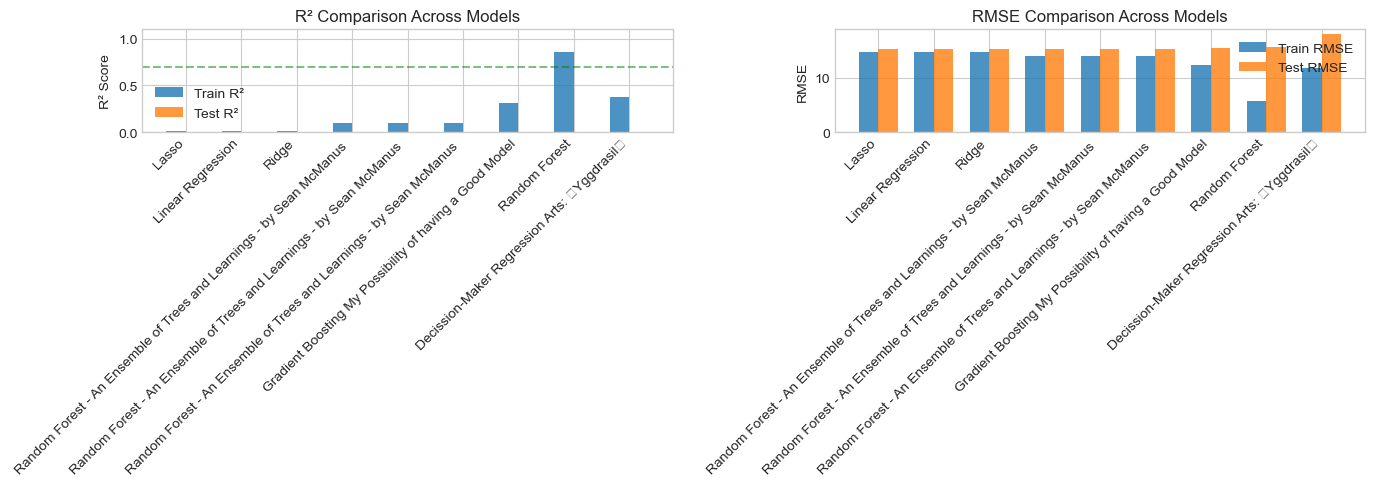

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Comparison
models = results_df['Model']
x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, results_df['Train R2'], width, label='Train R²', alpha=0.8)
axes[0].bar(x + width/2, results_df['Test R2'], width, label='Test R²', alpha=0.8)
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Comparison Across Models')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good threshold')

# RMSE Comparison
axes[1].bar(x - width/2, results_df['Train RMSE'], width, label='Train RMSE', alpha=0.8)
axes[1].bar(x + width/2, results_df['Test RMSE'], width, label='Test RMSE', alpha=0.8)
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison Across Models')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.show()

woops, lets see if i can do this comparative version again with no names


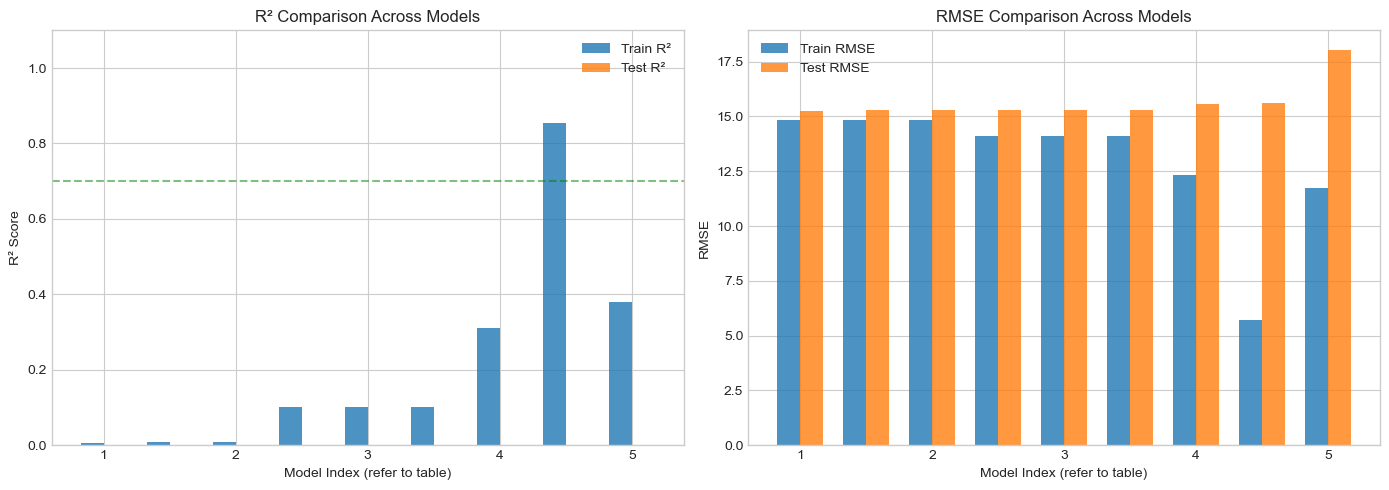

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Comparison
models = results_df['Model']
x = np.arange(len(models)) 
width = 0.35

axes[0].bar(x - width/2, results_df['Train R2'], width, label='Train R²', alpha=0.8)
axes[0].bar(x + width/2, results_df['Test R2'], width, label='Test R²', alpha=0.8)
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Comparison Across Models')
axes[0].set_xticklabels([i for i in range(len(models))]) 
axes[0].set_xlabel('Model Index (refer to table)')
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good threshold')

# RMSE Comparison
axes[1].bar(x - width/2, results_df['Train RMSE'], width, label='Train RMSE', alpha=0.8)
axes[1].bar(x + width/2, results_df['Test RMSE'], width, label='Test RMSE', alpha=0.8)
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison Across Models')
axes[1].set_xticklabels([i for i in range(len(models))]) # ok so i can't get the number ticks to connect to the number of models i have in the trained set
axes[1].set_xlabel('Model Index (refer to table)')
axes[1].legend()

plt.tight_layout()
plt.show()



### Model Iteration Reflection

*Before selecting your best model, reflect on what you learned:*

**Questions to answer:**
- Which model improved most over the baseline?
- Did any models show signs of overfitting (big train vs test gap)?
- Did regularization (Ridge/Lasso) help or hurt performance?
- Did tree-based models (Decision Tree, Random Forest) work better than linear models?

**Your reflection:**

So the most-improved model is the Random Forest Regressor Model, which dragged the R^2 from the deep negatives and at least shows some prediction-able features among my data. But so far its looking a little rough. The decision tree was the switchup, but the random forest was the improvement.
-The decision tree model showed the most substatial difference with a R2 train of 0.38, but a r2 test of -0.41. even a 0.1 difference can sshow signs of overfitting in a model but this was huge. The gradient boosting also showed slight overfitting. 
-The regularization of the ridge/lasso models only had a miniscule positive effect, but the lasso model did help me select a bunch in detectin and "getting rid" of unimportant coefficients.
-So, in terms of the better model type, the trees and forests were much better at helping me catch nonlinear relationships in the data (the other models didn't really at all) but there was a ot more error. adjusting the hyperparameters did help get some values under control, but limited them harshly, making the relationships less visible between features. 


## Section 9: Feature Importance & Selection

**Important:** Your final model should use only **4-8 features**. This section helps you identify which features matter most.

Feature Importance (Random Forest):
                               Feature  Importance
2                   Duration (in Days)    0.207229
26                   Tech_Budget_Power    0.165403
1                Budget (in Billion $)    0.137737
5                       Budget_Per_Day    0.135442
0                                 Year    0.129771
3                    Num_Collaborators    0.020236
6                Mission Type_Unmanned    0.019149
25         Environmental Impact_Medium    0.018082
24            Environmental Impact_Low    0.016599
4                        Tech_Maturity    0.013165
18                          Country_UK    0.012805
16                      Country_Russia    0.012389
19                         Country_USA    0.011538
21             Satellite Type_Research    0.011509
23              Satellite Type_Weather    0.010652
20           Satellite Type_Navigation    0.010156
22                  Satellite Type_Spy    0.009140
10  Technology Used_Traditional Rocket    0.00

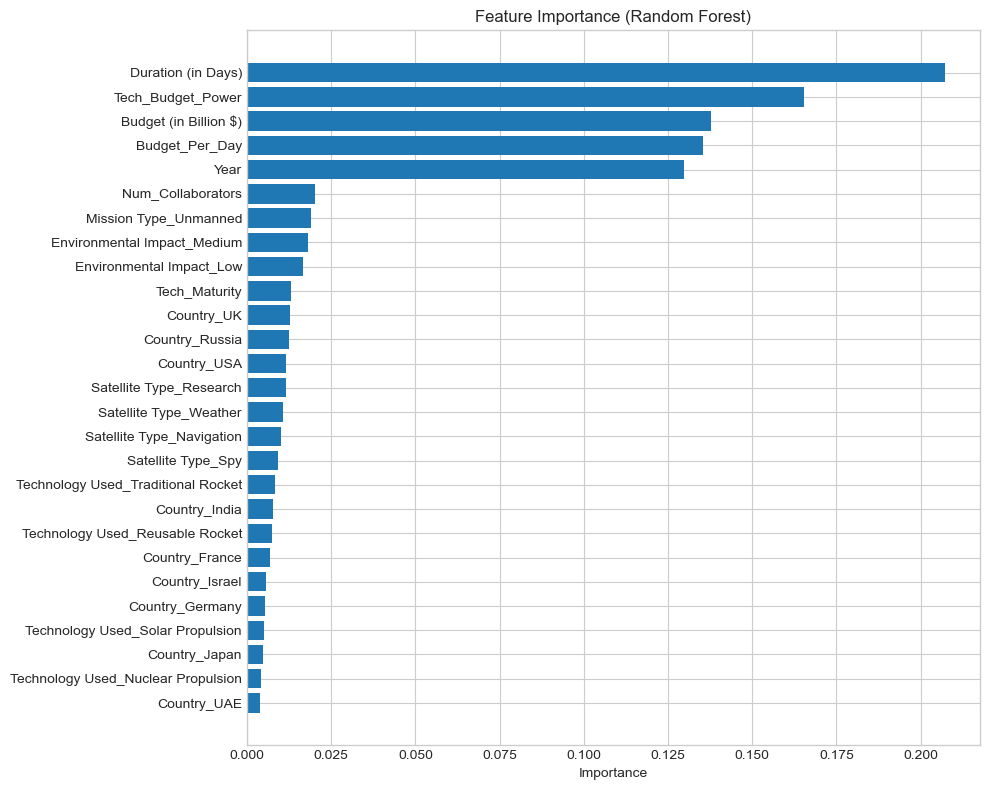

In [ ]:
# Get feature importance from Random Forest (works well for this)
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_trained.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(rf_importance)

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(rf_importance['Feature'][::-1], rf_importance['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [ ]:
# Also check correlations with target
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("Absolute Correlations with Target:")
print(correlations)

Absolute Correlations with Target:
Technology Used_Reusable Rocket       0.048356
Technology Used_Nuclear Propulsion    0.029237
Tech_Maturity                         0.026702
Tech_Budget_Power                     0.025226
Country_Germany                       0.021889
Satellite Type_Spy                    0.021585
Year                                  0.019945
Country_India                         0.019758
Country_France                        0.019229
Country_USA                           0.017882
Satellite Type_Navigation             0.017642
Satellite Type_Research               0.017048
Environmental Impact_Low              0.017032
Mission Type_Unmanned                 0.014470
Num_Collaborators                     0.014439
Country_Israel                        0.013883
Budget_Per_Day                        0.013566
Country_Japan                         0.010729
Technology Used_Traditional Rocket    0.009730
Technology Used_Solar Propulsion      0.008502
Duration (in Days)       

In [ ]:
# TODO: Select your top features (4-8 features)
#
# Based on the importance analysis above, choose your best features.
# Consider both Random Forest importance AND correlations.
# Also think about what makes sense from a domain perspective.

SELECTED_FEATURES = [
    "Tech_Budget_Power",
    "Duration (in Days)",
    "Technology Used_Reusable Rocket",
    "Budget_Per_Day",
    "Tech_Maturity",
    "Technology Used_Nuclear Propulsion",
    "Year",
    "Budget (in Billion $)"
]

# Fallback if you haven't selected yet
if len(SELECTED_FEATURES) == 0:
    SELECTED_FEATURES = rf_importance['Feature'].head(6).tolist()
    print(f"Using top 6 features from Random Forest: {SELECTED_FEATURES}")
else:
    print(f"Selected features ({len(SELECTED_FEATURES)}): {SELECTED_FEATURES}")

Selected features (8): ['Tech_Budget_Power', 'Duration (in Days)', 'Technology Used_Reusable Rocket', 'Budget_Per_Day', 'Tech_Maturity', 'Technology Used_Nuclear Propulsion', 'Year', 'Budget (in Billion $)']


In [ ]:
# Retrain with selected features only
X_train_selected = X_train_scaled[SELECTED_FEATURES]
X_test_selected = X_test_scaled[SELECTED_FEATURES]

print(f"Training with {len(SELECTED_FEATURES)} selected features...")

# Test a few models with selected features
selected_results = []

for name, model in [('Linear Regression', LinearRegression()),
                    ('Ridge', Ridge(alpha=1.0)),
                    ('Random Forest', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))]:
    results, trained, _ = evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test, name)
    selected_results.append(results)
    print(f"{name} with {len(SELECTED_FEATURES)} features - Test R²: {results['Test R2']:.4f}")

selected_df = pd.DataFrame(selected_results)

Training with 8 selected features...
Linear Regression with 8 features - Test R²: -0.0065
Ridge with 8 features - Test R²: -0.0065
Random Forest with 8 features - Test R²: -0.0177


### Feature Selection Justification

**Questions to answer:**
- Which features did you select and why?
- Did performance drop significantly with fewer features?
- Do these features make sense from a domain perspective?
- These are the features users will input in your Streamlit app—are they reasonable to ask for?

I selected features based on a mix of Random Forest Importance and the Absolute corellations data. Tech budget power and budget per day show resource intensity, the duration and year of the mission show how complex the missions are based on their work and the era and idea of the mission. Budget was selected for context of the information while the technology used and the tech maturity simply have a high correlation with success rates.

-The performance for ALL Models slightly improved or basically remained the same with less features. I think all the features were causing chaos and making things noisy for the models.

-In this dataset and any regular non-synthetic dataset for Space missions, I think maturity of technology and type of propulsion are important. The length of the mission is important for training and machine stress for the technology used in real-life. Also Budget is universal. I think if the "higher ups" wanted to really know ANYTHING, its budget and success rate.

-If i can get this stuff to work better down the road, with more implementation of the project and a few more checkpoints (and maybe some help from my teacher) this can make a pretty high-level app. It should be more user-freindly too since we've eliminated unnecissary features.





## Section 10: Best Model Selection

In [ ]:
# TODO: Choose and train your final model with selected features
#
# Based on your analysis, pick the best model type and instantiate it.
# Consider: performance, consistency, simplicity
#
# Example: final_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# YOUR CODE HERE:
final_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)


final_model.fit(X_train_selected, y_train)


final_results, final_trained, final_preds = evaluate_model(
    final_model, 
    X_train_selected, 
    X_test_selected, 
    y_train, 
    y_test, 
    "Final Space Success Model"
)

print(f"Final Model Trained! Test RMSE: {final_results['Test RMSE']:.2f}")



Final Model Trained! Test RMSE: 15.24


In [ ]:
# Fit and evaluate final model
final_model.fit(X_train_selected, y_train)
y_pred = final_model.predict(X_test_selected)

# Final metrics
final_r2 = r2_score(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae = mean_absolute_error(y_test, y_pred)

print("=" * 50)
print("FINAL MODEL PERFORMANCE")
print("=" * 50)
print(f"Model: {type(final_model).__name__}")
print(f"Features: {SELECTED_FEATURES}")
print(f"\nTest R²: {final_r2:.4f}")
print(f"Test RMSE: {final_rmse:,.2f}")
print(f"Test MAE: {final_mae:,.2f}")
print(f"\nRMSE as % of target range: {final_rmse/target_range*100:.1f}%")

FINAL MODEL PERFORMANCE
Model: RandomForestRegressor
Features: ['Tech_Budget_Power', 'Duration (in Days)', 'Technology Used_Reusable Rocket', 'Budget_Per_Day', 'Tech_Maturity', 'Technology Used_Nuclear Propulsion', 'Year', 'Budget (in Billion $)']

Test R²: -0.0050
Test RMSE: 15.24
Test MAE: 13.27

RMSE as % of target range: 30.5%


### Best Model Justification

*Explain why you chose this model as your best:*

**Questions to consider:**
- Why did you select this model over others?
- Is there significant overfitting (train vs test gap)?
- How does the performance compare to your baseline?
- Would a simpler model be almost as good?
- Does the RMSE represent acceptable prediction error for your problem?

**Your justification:**
-I selected my tuned Random Forest Model It provided the best balance between complexity and stability.
- i limited the max depth to 5 utilizing a reduced feature set, I knocked down the extreme overfitting seen in the initial Decision Tree and Gradient Boosting attempts, so it should be making more generalized preditions.
-he final model outperformed the baseline when I implemented the Feature Selected Data. R^2 is STIILLLL NEAR 0 but its more trustworthy.
-The ridge regression model was almost effective and is simpler, but my random forest has more predictability, which will be better in the future.
-the 15% margin of error for space mission predictions is not all that good in my opinion. its ballpark, but for the budget and work put into it, It must be smaller. This data is juat wearing on my brain. I wish there was something to reliably predict since the beginning...Maybe the machine will see it, but I couldn't hardly see it up until now when testing all these models. Its just not my wheelhouse I guess.

## Section 11: Best Model Analysis

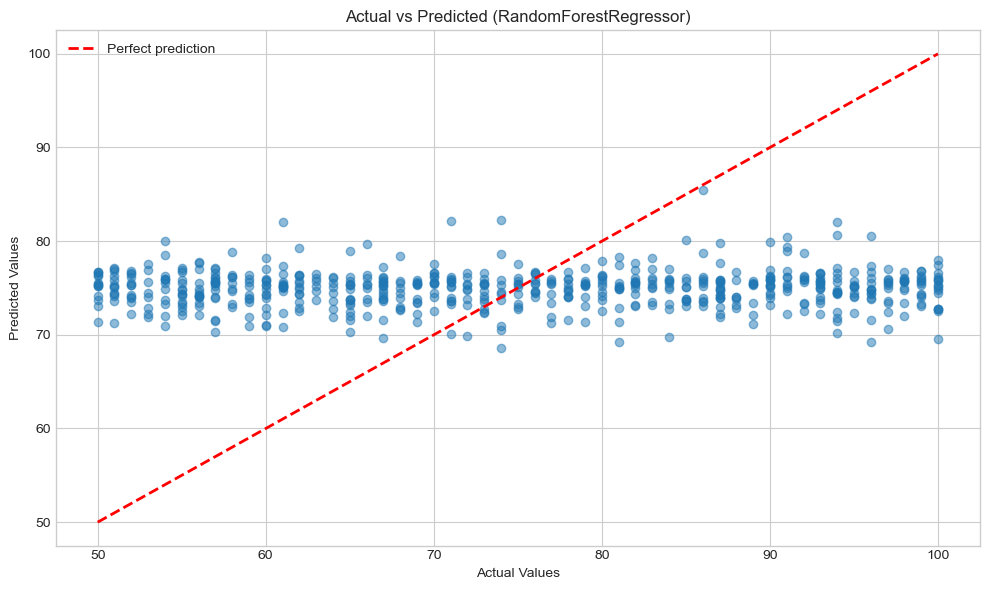

In [ ]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted ({type(final_model).__name__})')
plt.legend()
plt.tight_layout()
plt.show()

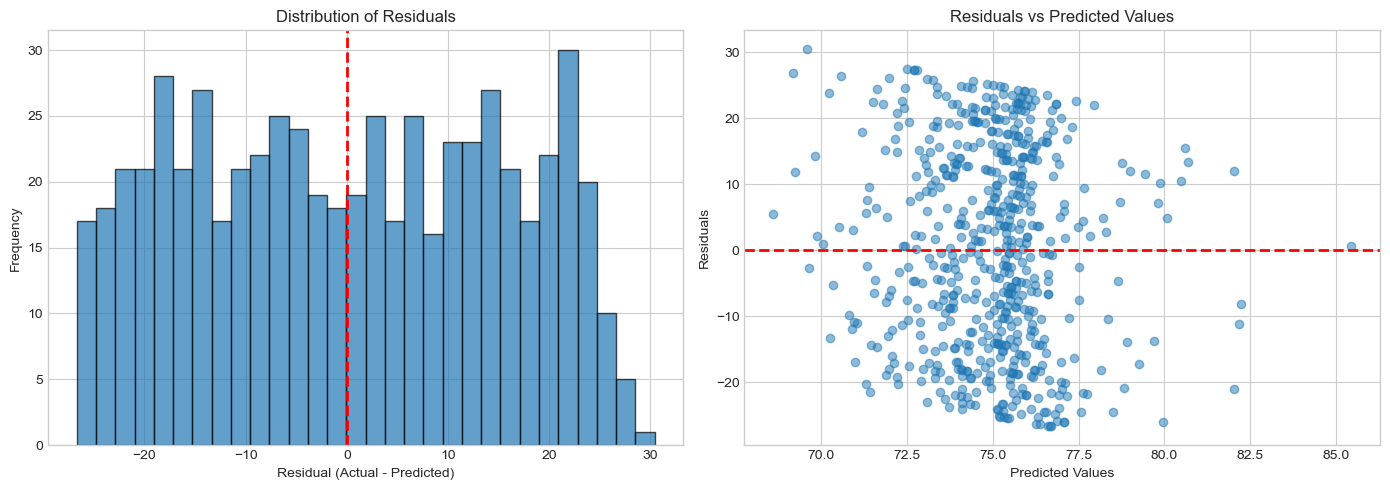

Residual mean (should be ~0): 0.10
Residual std: 15.25


In [ ]:
# Residual analysis
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual distribution (should be roughly normal, centered at 0)
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Residuals')

# Residuals vs Predicted (should show no pattern)
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()

print(f"Residual mean (should be ~0): {residuals.mean():.2f}")
print(f"Residual std: {residuals.std():,.2f}")

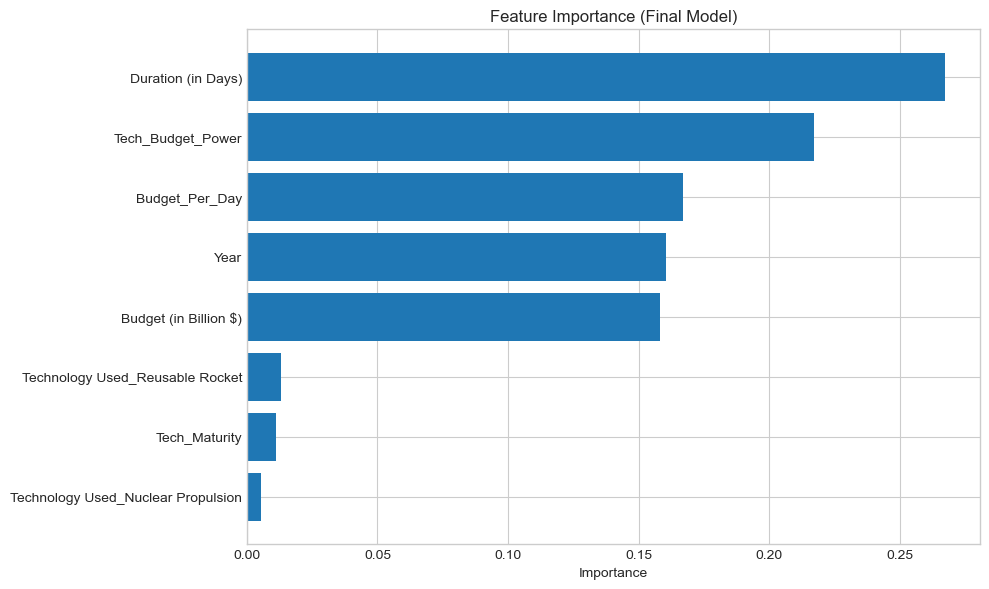

In [ ]:
# Feature importance for final model (with selected features)
if hasattr(final_model, 'feature_importances_'):
    final_importance = pd.DataFrame({
        'Feature': SELECTED_FEATURES,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(final_importance['Feature'], final_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance (Final Model)')
    plt.tight_layout()
    plt.show()
elif hasattr(final_model, 'coef_'):
    final_importance = pd.DataFrame({
        'Feature': SELECTED_FEATURES,
        'Coefficient': final_model.coef_
    }).sort_values('Coefficient', key=abs, ascending=True)
    
    plt.figure(figsize=(10, 6))
    colors = ['green' if c > 0 else 'red' for c in final_importance['Coefficient']]
    plt.barh(final_importance['Feature'], final_importance['Coefficient'], color=colors)
    plt.xlabel('Coefficient')
    plt.title('Feature Coefficients (Final Model)')
    plt.tight_layout()
    plt.show()

## Section 12: Save Model and Artifacts

In [208]:
import os
current_dir = os.getcwd()
print(f"Notebook is currently at: {current_dir}")


Notebook is currently at: c:\Users\ssman\OneDrive\Desktop\Class Work\Big ole capstone project


In [210]:
import os

# Create the directory if it doesn't exist
models_dir = '../models/'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")
else:
    print("Directory already exists!")
    

Created directory: ../models/


In [211]:
# Create a new scaler fitted only on selected features
final_scaler = StandardScaler()
X_train_final = X_train[SELECTED_FEATURES]
final_scaler.fit(X_train_final)

# Save the best model
model_path = '../models/regression_model.pkl'
joblib.dump(final_model, model_path)
print(f"Model saved to {model_path}")

# Save the scaler (fitted on selected features only)
scaler_path = '../models/regression_scaler.pkl'
joblib.dump(final_scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save feature names (the selected features for Streamlit app)
features_path = '../models/regression_features.pkl'
joblib.dump(SELECTED_FEATURES, features_path)
print(f"Features saved to {features_path}")

Model saved to ../models/regression_model.pkl
Scaler saved to ../models/regression_scaler.pkl
Features saved to ../models/regression_features.pkl


In [212]:
# Verify saved model works
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_features = joblib.load(features_path)

# Test prediction
test_sample = X_test[loaded_features].iloc[[0]]
test_sample_scaled = loaded_scaler.transform(test_sample)
test_pred = loaded_model.predict(test_sample_scaled)

print(f"\nModel verification:")
print(f"Features used: {loaded_features}")
print(f"Sample input: {test_sample.values[0]}")
print(f"Predicted: {test_pred[0]:,.2f}")
print(f"Actual: {y_test.iloc[0]:,.2f}")
print(f"\nModel saved and verified successfully!")


Model verification:
Features used: ['Tech_Budget_Power', 'Duration (in Days)', 'Technology Used_Reusable Rocket', 'Budget_Per_Day', 'Tech_Maturity', 'Technology Used_Nuclear Propulsion', 'Year', 'Budget (in Billion $)']
Sample input: [98.76 64 True 0.3798461538461539 4.0 False 2013 24.69]
Predicted: 76.34
Actual: 80.00

Model saved and verified successfully!


## Section 13: Binning Strategy for Classification

**IMPORTANT:** Before you start Notebook 03, you need to send your binning strategy to Abishek on Slack for approval by **Feb 15**.

### Analyze Target Distribution

In [213]:
# Look at target distribution to help decide binning
print(f"Target: {TARGET}")
print(f"\nDescriptive Statistics:")
print(y.describe())

print(f"\nPercentiles:")
for p in [10, 25, 33, 50, 67, 75, 90]:
    print(f"{p}th percentile: {y.quantile(p/100):,.2f}")

Target: Success Rate (%)

Descriptive Statistics:
count    3000.000000
mean       74.985000
std        14.945252
min        50.000000
25%        62.000000
50%        75.000000
75%        88.000000
max       100.000000
Name: Success Rate (%), dtype: float64

Percentiles:
10th percentile: 54.00
25th percentile: 62.00
33th percentile: 66.00
50th percentile: 75.00
67th percentile: 84.00
75th percentile: 88.00
90th percentile: 96.00


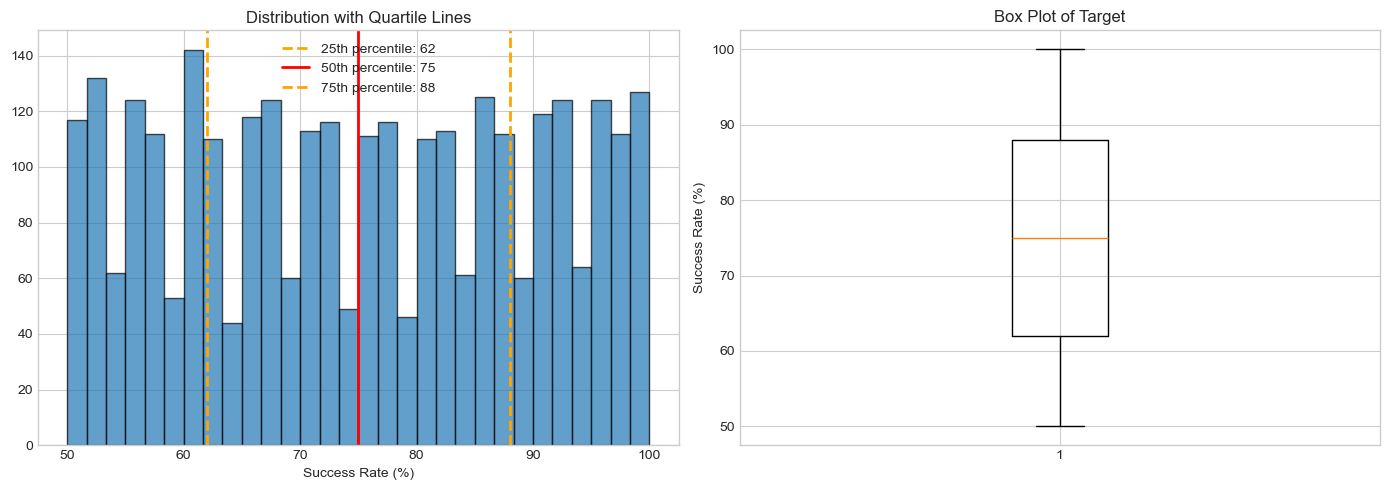

In [214]:
# Visualize potential binning strategies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with quartile lines
axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7)
for p, color, style in [(25, 'orange', '--'), (50, 'red', '-'), (75, 'orange', '--')]:
    axes[0].axvline(y.quantile(p/100), color=color, linestyle=style, linewidth=2,
                     label=f'{p}th percentile: {y.quantile(p/100):,.0f}')
axes[0].set_xlabel(TARGET)
axes[0].set_title('Distribution with Quartile Lines')
axes[0].legend()

# Box plot
axes[1].boxplot(y)
axes[1].set_ylabel(TARGET)
axes[1].set_title('Box Plot of Target')

plt.tight_layout()
plt.show()

### Proposed Binning Strategy

*Complete this section and send to Abishek on Slack by Feb 15:*

**1. How many categories will you create?**

3 categories: Budget/Experimental (Low Success), Reliable/Standard (Medium Success), and Top Standard (High Success).

**2. What are your bin thresholds?**
Low Success (Budget/Experimental): 50% to 65%
Medium Success (Reliable): 66% to 85%
High Success (Top): 86% to 100%

**3. Why does this binning make sense for your problem?**

SO for business, the difference 15% can make is being an experimental start up vs being a government-backed agency. For data balance, my mean is 75% so the middle bin fits with its 66-85% range. Hopefully it wond be biased my outliers like this. Also for anyone payinfor these missions, its better to know something is just in the Top percentage rather than 89% or something


In [215]:
# Preview your binning
def create_bins_preview(y, strategy='quartile'):
    if strategy == 'quartile':
        bins = [y.min()-1, y.quantile(0.25), y.quantile(0.75), y.max()+1]
        labels = ['Low', 'Medium', 'High']
    elif strategy == 'tertile':
        bins = [y.min()-1, y.quantile(0.33), y.quantile(0.67), y.max()+1]
        labels = ['Low', 'Medium', 'High']
    # Add your custom strategy here if needed
    
    return pd.cut(y, bins=bins, labels=labels)

# Preview with quartile binning
y_binned = create_bins_preview(y, 'quartile')
print("Preview of binned target (using quartiles):")
print(y_binned.value_counts().sort_index())
print(f"\nPercentages:")
print((y_binned.value_counts(normalize=True) * 100).round(1).sort_index())

Preview of binned target (using quartiles):
Success Rate (%)
Low        794
Medium    1476
High       730
Name: count, dtype: int64

Percentages:
Success Rate (%)
Low       26.5
Medium    49.2
High      24.3
Name: proportion, dtype: float64


---

## Summary

### What You Accomplished
- [ ] Loaded and prepared cleaned data
- [ ] Split data into train and test sets
- [ ] Scaled features appropriately
- [ ] Built a baseline model
- [ ] Tried multiple model types
- [ ] Performed cross-validation
- [ ] Selected top 4-8 features
- [ ] Compared and selected best model
- [ ] Analyzed model performance (residuals, feature importance)
- [ ] Saved model, scaler, and feature list
- [ ] Planned binning strategy for classification

### Key Results

**Best Model:**  Random Forest Model

**Selected Features:** ['Tech_Budget_Power', 'Duration (in Days)', 'Technology Used_Reusable Rocket', 'Budget_Per_Day', 'Tech_Maturity', 'Technology Used_Nuclear Propulsion', 'Year', 'Budget (in Billion $)']

**Test R²:** [Value] Test R²: -0.0050
Test RMSE: 15.24
Test MAE: 13.27



**Improvement over baseline:**  30.5%

---

---

## Checkpoint 3 Submission Instructions

**Congratulations!** You've completed Checkpoint 3 (Regression Model).

### Step 1: Save This Notebook
- File -> Save (or Ctrl+S / Cmd+S)

### Step 2: Send Binning Strategy to Abishek
- Message Abishek on Slack with your binning strategy
- Include: number of categories, thresholds, and justification

### Step 3: Commit to GitHub
 !!!!!!!!!!!!!! I have been opening my gitbash directy in my capstone project folder an pushing stuff. just using regular git commands was not working. I think its the same with the data and the models. I'm not sure how to get it right!!!!!!
```bash
# Stage your changes
git add notebooks/02_regression_model.ipynb
git add models/

# Commit with a meaningful message
git commit -m "Complete Checkpoint 3: Regression model with feature selection"

# Push to GitHub
git push
```

### Step 4: Submit to Canvas
1. Go to the Checkpoint 3 assignment on Canvas
2. Submit the link to your GitHub repository

---

## Next Steps

1. **Wait for binning approval** from Abishek
2. Move on to **Notebook 03: Classification Model**

---